In [1]:
# jupyteronly
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
# generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
import numpy as np
import yaml
import rioxarray as rxr
import glob

# Import functions to load and stack data without datacube
from notebook_functions import *

import dask
import dask.array as da
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, memory_limit='7GB')

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36663/status,
Dashboard: http://127.0.0.1:36663/status,Workers: 2
Total threads: 8,Total memory: 13.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36333,Workers: 2
Dashboard: http://127.0.0.1:36663/status,Total threads: 8
Started: Just now,Total memory: 13.04 GiB
Comm: tcp://127.0.0.1:36787,Total threads: 4
Dashboard: http://127.0.0.1:45703/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:41565,


## Set Up Parameters

In [3]:
# Running locally on landsat 8 data for now
baseline_product = 'landsat_8'
baseline_measurement = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

analysis_product = 'landsat_8'
analysis_measurement = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

# St Maarten bounding box to subset the data
clip_coords = {'min_lon':-63.461424,
               'min_lat': 17.950000,
               'max_lon': -62.80000,
               'max_lat': 18.334848}

# Set size of dask chunks to use for the scenes
dask_chunks = dict(
    x = 1000,
    y = 1000
)

## Load Data

In [4]:
def prep_dataset(in_dir, measurement, product, clip_coords = None):
    """Prepare either the baseline or analysis dataset."""
    scenes = glob.glob(f'{in_dir}/*/')

    array_list = []

    for scene in scenes:
        yml = f'{scene}/datacube-metadata.yaml'
        with open (yml) as stream: yml_meta = yaml.safe_load(stream)

        # Load the bands provided in 'measurement' from the yaml file.
        o_bands_data = [ rxr.open_rasterio(scene + yml_meta['image']['bands'][b]['path'], chunks=dask_chunks) for b in measurement ] 

        # Clip the data to the bounding box if provided.
        if clip_coords is not None:
            o_bands_data = [ o_bands_data[i].rio.clip_box(minx = clip_coords['min_lon'], miny = clip_coords['min_lat'], 
                                                          maxx = clip_coords['max_lon'], maxy = clip_coords['max_lat']) 
                                                          for i in range(len(o_bands_data)) ]

        # Get the timestamp from the yaml file.
        timestamp = datetime.strptime(yml_meta['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')

        # Stack the bands together into a single xarray dataset.
        band_data = stack_bands(o_bands_data, measurement, timestamp)

        # Append each stacked scene to a list to be combined later.
        array_list.append(band_data)

    # Stack the scenes together into xarray dataset.
    ds = stack_scenes(array_list)

    # Mask out nodata values.
    ds = ds.where(ds != -9999)
    print(f'Final Dataset: {ds}')

    return ds

In [5]:
# Run data for St Maarten Baseline
baseline_dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat_baseline/'
baseline_ds = prep_dataset(baseline_dir, baseline_measurement, baseline_product, clip_coords)

## Run data for the Tile7572 baseline
# baseline_dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/BaselineData/'
# baseline_ds = prep_dataset(baseline_dir, baseline_measurement, baseline_product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 4, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2018-09-06 2018-11-09 ... 2018-03-14
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000),

In [6]:
# St Maarten Analysis
analysis_dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat_analysis/'
analysis_ds = prep_dataset(analysis_dir, analysis_measurement, analysis_product, clip_coords)

# # Run data for the Tile7572 analysis
# analysis_dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/AnalysisData/'
# analysis_ds = prep_dataset(analysis_dir, analysis_measurement, analysis_product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 3, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2022-11-20 2022-12-22 2022-10-19
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), met

### Mask Out NoData Values

In [11]:
#baseline_ds = baseline_ds.where(baseline_ds != -9999)
#analysis_ds = analysis_ds.where(analysis_ds != -9999)

## Cloud and Water Masking
Mask out clouds and water to look only at land.

In [8]:
# Use the landsat clean mask function to mask out clouds and water.
clean_mask_baseline = ls_clean_mask(baseline_ds)
clean_mask_analysis = ls_clean_mask(analysis_ds)

## Create Mosaics

In [9]:
# create_median_mosaic function is originally from ard-docker-images (originally from datacube-utilities)
# Including only shortened version of the function here

def create_median_mosaic(dataset_in, clean_mask=None, no_data=-9999, dtype=None, **kwargs):
    """
    Method for calculating the median pixel value for a given dataset.
    """
   
    # Mask nodata, clouds and water.
    dataset_in = dataset_in.where((dataset_in != -9999) & clean_mask==True)

    # Calculate median over time dimension.
    dataset_out = dataset_in.median(dim='time', skipna=True, keep_attrs=False)

    return dataset_out

In [29]:
# Create composites (summarizing through time) of the baseline and analysis datasets
baseline_composite = create_median_mosaic(baseline_ds, clean_mask=clean_mask_baseline, no_data=np.nan)
analysis_composite = create_median_mosaic(analysis_ds, clean_mask=clean_mask_analysis, no_data=np.nan)

### Visualize Composites

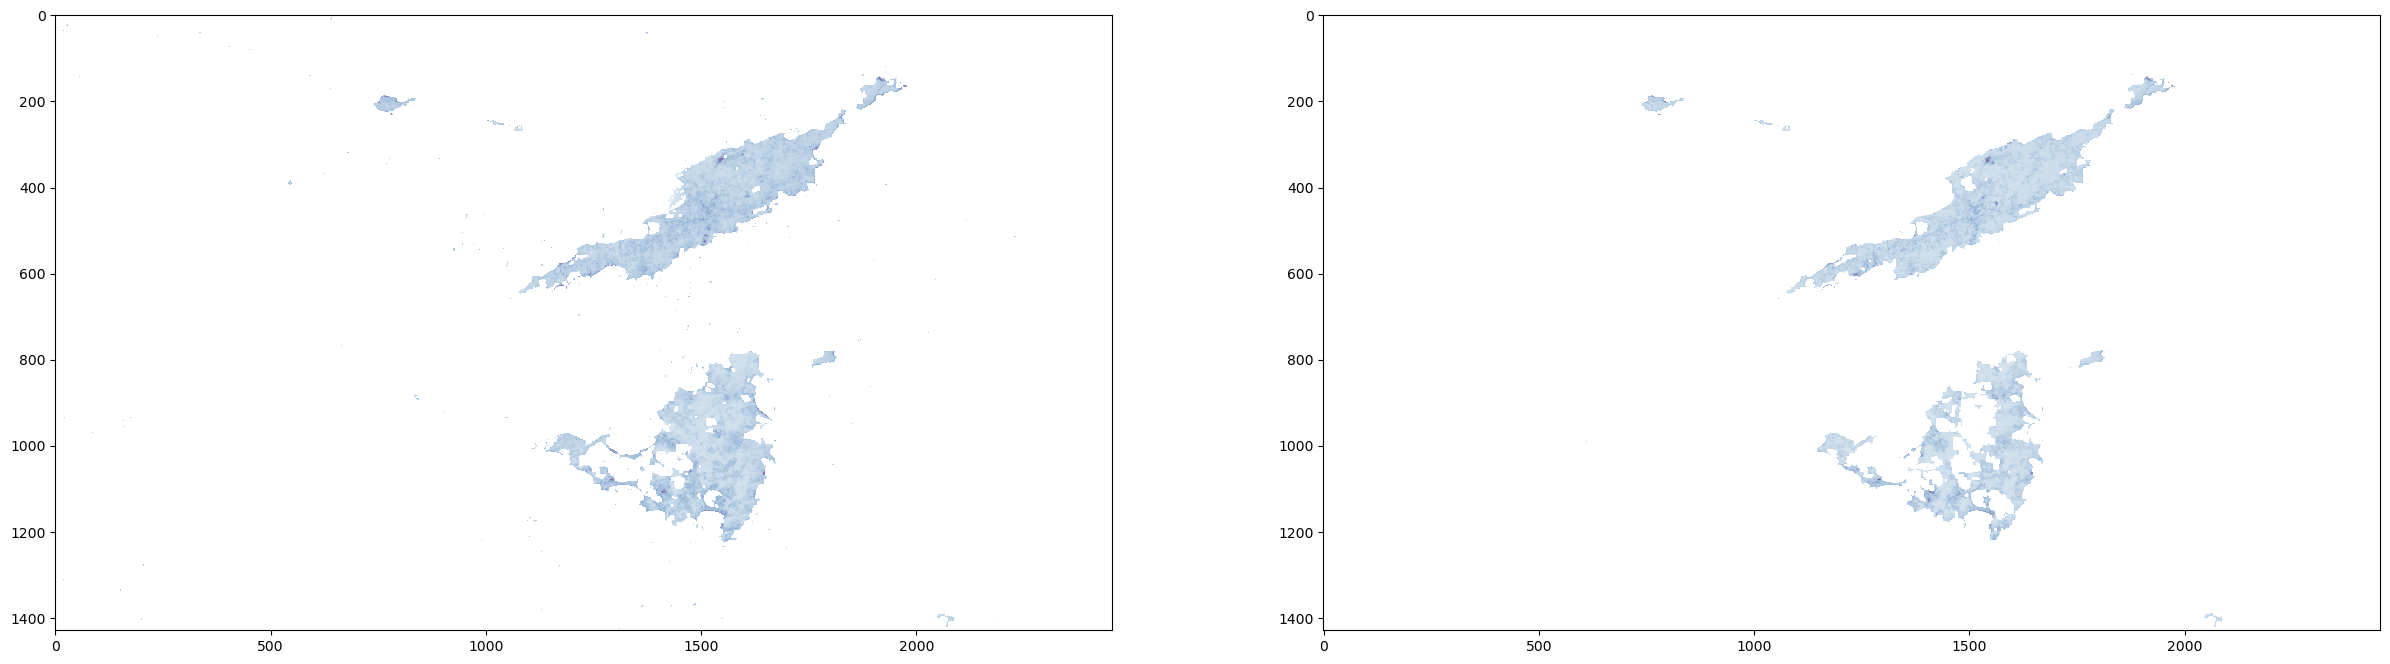

In [30]:
# Plot a band from the composites (e.g. blue)
fig, ax = plt.subplots(1, 2, figsize=(30,30))
ax[0].imshow(baseline_composite.nir, cmap='BuPu')
ax[1].imshow(analysis_composite.nir, cmap='BuPu')

In [ ]:
#baseline_composite.nir.rio.to_raster(f"Composite_Baseline_NIR.tif", dtype="float32", driver='COG')
#analysis_composite.nir.rio.to_raster(f"Composite_Analysis_NIR.tif", dtype="float32", driver='COG')

## Spectral Indices

In [31]:
def NDVI(dataset):
    NDVI = (dataset.nir - dataset.red)/(dataset.nir + dataset.red)
    NDVI = NDVI.where(dataset.nir.notnull() & dataset.red.notnull())
    return NDVI

In [32]:
# Calculate NDVI composite for both datasets
parameter_baseline_composite = NDVI(baseline_composite)
parameter_analysis_composite = NDVI(analysis_composite)


# Use stack arrays with composite time handling to align composites before calculations.
parameter_analysis_composite, parameter_baseline_composite = stack_arrays([parameter_analysis_composite, parameter_baseline_composite], parameter_analysis_composite, time_handling='Composites')

### Visualize NDVI Composites

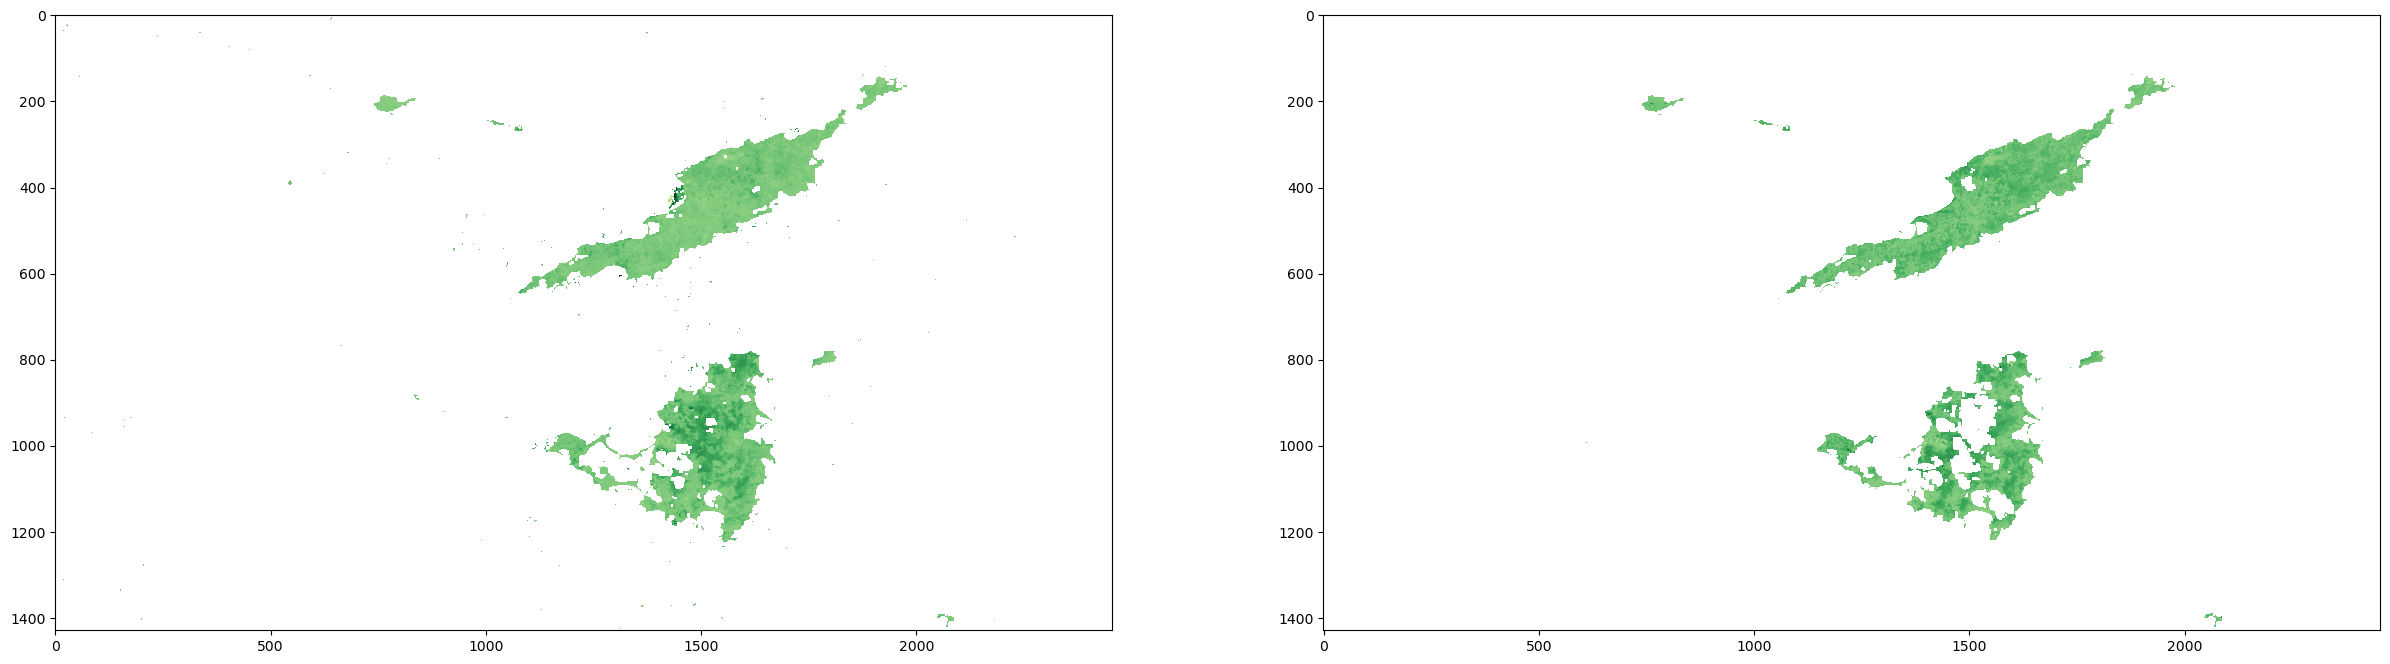

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(30,30))
ax[0].imshow(parameter_baseline_composite.squeeze(), cmap='YlGn_r', vmin=-1, vmax=1)
ax[1].imshow(parameter_analysis_composite.squeeze(), cmap='YlGn_r', vmin=-1, vmax=1)

## Calculate Parameter Anomaly

In [40]:
# Calculate NDVI Anomaly
parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite

### Visualize Parameter Anomaly

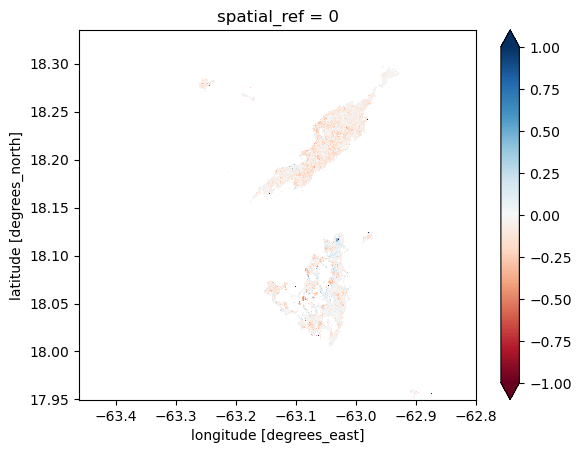

In [41]:
parameter_anomaly.plot.imshow(cmap='RdBu', vmin=-1, vmax=1)

## Export Desired Data

In [26]:
parameter_analysis_composite.rio.to_raster(f"StMaarten_NDVI_Analysis_Composite.tif", dtype="float32", driver='COG')
parameter_baseline_composite.rio.to_raster(f"StMaarten_NDVI_Baseline_Composite.tif", dtype="float32", driver='COG')
parameter_anomaly.rio.to_raster(f"StMaarten_NDVIAnomaly.tif", dtype="float32", driver='COG')